# Web-приложение с нейронкой по оценке стоимости авто

### Подключение библиотек и скриптов

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv

--2024-10-29 11:12:12--  https://storage.yandexcloud.net/academy.ai/japan_cars_dataset.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136735 (134K) [text/csv]
Saving to: ‘japan_cars_dataset.csv’

japan_cars_dataset. 100%[===================>] 133.53K   248KB/s    in 0.5s    

2024-10-29 11:12:14 (248 KB/s) - ‘japan_cars_dataset.csv’ saved [136735/136735]



In [ ]:
DATASET_PATH = 'japan_cars_dataset.csv'

**Описание датасета**

* **price** - Цена продажи автомобиля в объявлении.
* **mark** - Марка автомобиля.
* **model** - Модель автомобиля.
* **year** - Год регистрации автомобиля.
* **mileage** - Мили, пройденные автомобилем.
* **engine_capacity** - Объем двигателя автомобиля.
* **transmission** - Тип коробки передач автомобиля.
* **drive** - Привод автомобиля.
* **hand_drive** - Располжение руля (слева / справа) в автомобиле.
* **fuel** - Тип топлива, используемого автомобилем.

In [ ]:
df = pd.read_csv(DATASET_PATH, sep=',', index_col=0)
df.tail(3)

,price,mark,model,year,mileage,engine_capacity,transmission,drive,hand_drive,fuel
2333,1400,subaru,r2,2005,101000,660,cvt,2wd,rhd,gasoline
2334,1400,honda,z,2000,170000,660,at,4wd,rhd,gasoline
2335,1400,toyota,estima t,2005,72320,3000,at,2wd,rhd,gasoline


### Формирование выборок

In [ ]:
X = df.drop('price', axis=1)
y = df['price']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=0)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle=True, random_state=0)

### Pipeline

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Преобразователь для выбора одного столбца из дата фрейма
    для выполнения дополнительных преобразований
    Использовать в числовых столбцах данных
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [ ]:
categorical_columns = ['mark', 'model', 'transmission', 'drive', 'hand_drive', 'fuel']
continuous_columns = ['year', 'mileage', 'engine_capacity']

In [ ]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('standard', StandardScaler())
    ])
    final_transformers.append((cont_col, cont_transformer))

In [ ]:
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

In [ ]:
pipeline = Pipeline([
    ('features',feats),
    ('regressor', GradientBoostingRegressor())
    ])

In [ ]:
#обучим пайплайн
pipeline.fit(x_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('mark',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='mark')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='mark'))])),
                                                ('model',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='model')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='model'))])),
                                                ('transmission',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='transmission')),...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='year')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('mileage',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='mileage')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('engine_capacity',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='engine_capacity')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('regressor', GradientBoostingRegressor())])

In [ ]:
x = {'mark'           :   'subaru',
     'model'          :  'impreza',
     'year'           :       2008,
     'mileage'        :     127000,
     'engine_capacity':       1500,
     'transmission'   :       'at',
     'drive'          :      '2wd',
     'hand_drive'     :      'rhd',
     'fuel'           : 'gasoline'}

In [ ]:
y = pipeline.predict(pd.DataFrame(pd.Series(x)).T)
y[0]

986.3380160299173

## Установка и первый запуск

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/

In [ ]:
import gradio as gr

# mark
mark = df['mark'].unique().tolist()

# model
model = {mark: df.loc[df['mark'] == mark]['model'].unique().tolist() for mark in df['mark'].unique()}

# years
model_years = {model: df.loc[df['model'] == model]['year'].unique() for model in df['model'].unique()}
year_func = lambda year: list(range(year.min(), year.max()+1))
model_years = {model: year_func(years) for model, years in model_years.items()}

# mileage
value_mileage, max_mileage = int(df['mileage'].mean()), df['mileage'].max()
model_mileages = {model: df.loc[df['model'] == model]['mileage'].unique() for model in df['model'].unique()}
model_min_max_mileages = {model: list(map(lambda x: int(round(x, -3)), (mils.min()-1e4, mils.mean(), mils.max()+1e4)))
                         for model, mils in model_mileages.items()}

# engine_capacity
model_ec = {model: df.loc[df['model'] == model]['engine_capacity'].sort_values().unique().tolist() for model in df['model'].unique()}

# transmission, drive, hand_drive, fuel
radio_lambda = lambda col: {model: list(map(str.upper, df.loc[df['model'] == model][col].unique())) for model in df['model'].unique()}
model_transmission, model_drive, model_hand_drive, model_fuel = list(map(radio_lambda, ['transmission', 'drive', 'hand_drive', 'fuel']))

with gr.Blocks() as demo:
    x_mark = gr.Dropdown(choices=mark, label="Марка автомобиля")
    x_model = gr.Dropdown([], label="Модел автомобиля")
    x_year = gr.Dropdown([], label="Год регистрации автомобиля")
    x_mileage = gr.Slider(label="Мили, пройденные автомобилем", value=value_mileage, minimum=0, maximum=max_mileage, step=1000)
    x_ec = gr.Radio([], label="Объем двигателя автомобиля, мл")
    x_tr = gr.Radio([], label="Тип коробки передач автомобиля")
    x_drive = gr.Radio([], label="Привод автомобиля")
    x_hand_drive = gr.Radio([], label="Располжение руля (слева / справа) в автомобиле")
    x_fuel = gr.Radio([], label="Тип топлива, используемого автомобилем")

    def update_model(mark):
        return gr.Dropdown(model[mark])

    def update_year(model):
        return gr.Dropdown(model_years[model])

    def update_mileage(model):
        minimum, value, maximum = model_min_max_mileages[model]
        if minimum < 0: minimum = 0
        return gr.Slider(value=value, minimum=minimum, maximum=maximum, step=1000)

    def update_ec(model):
        return gr.Radio(model_ec[model])

    def update_tr(model):
        return gr.Radio(model_transmission[model])

    def update_drive(model):
        return gr.Radio(model_drive[model])

    def update_hand_drive(model):
        return gr.Radio(model_hand_drive[model])

    def update_fuel(model):
        return gr.Radio(model_fuel[model])

    x_mark.input(update_model, x_mark, x_model)
    x_model.input(update_year, x_model, x_year)
    x_model.input(update_mileage, x_model, x_mileage)
    x_model.input(update_ec, x_model, x_ec)
    x_model.input(update_tr, x_model, x_tr)
    x_model.input(update_drive, x_model, x_drive)
    x_model.input(update_hand_drive, x_model, x_hand_drive)
    x_model.input(update_fuel, x_model, x_fuel)

    outputs = gr.Textbox()

    def my_predict(mark, model, years, mileage, engine_capacity, transmission, drive, hand_drive, fuel):
        x = {'mark'           :            mark,
             'model'          :           model,
             'year'           :           years,
             'mileage'        :         mileage,
             'engine_capacity': engine_capacity,
             'transmission'   :    transmission,
             'drive'          :           drive,
             'hand_drive'     :      hand_drive,
             'fuel'           :            fuel}

        y = pipeline.predict(pd.DataFrame(pd.Series(x)).T)
        return f"Стоимоть выбранного автомобиля {int(y[0])}$"

    x_fuel.input(my_predict, [x_mark, x_model, x_year, x_mileage, x_ec, x_tr, x_drive, x_hand_drive, x_fuel], outputs)

    clear_button = gr.ClearButton([x_mark, x_model, x_year, x_mileage, x_ec, x_tr, x_drive, x_hand_drive, x_fuel, outputs])

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b496d9abb1cb186790.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Результат выполнения кода:

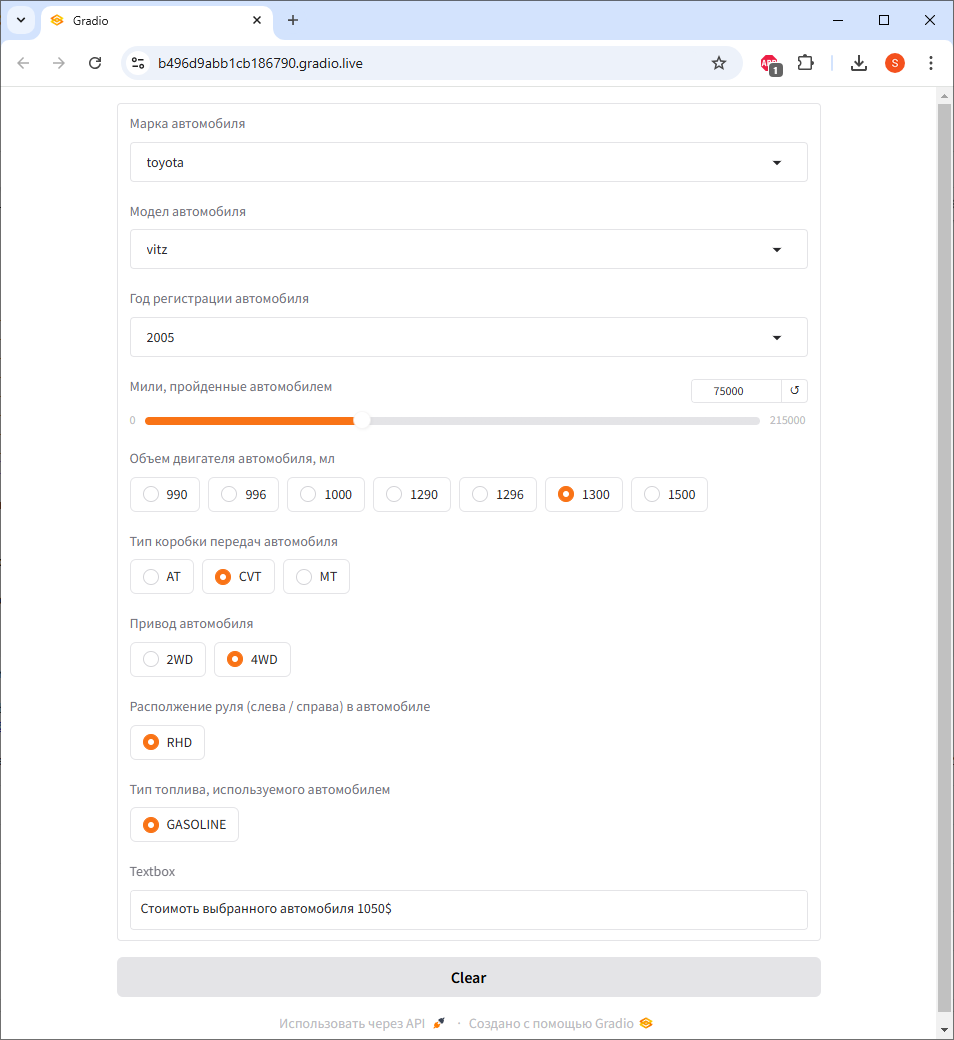